# Volatility smile option pricing model

We implement an option pricing model based on a quadratic volatility smile. The main reference is "The Volatility Smile" by Derman and Miller (Wiley 2016).



## Set-up

In [1]:
from scipy.stats import norm
import scipy.stats
from math import log, exp, sqrt
from matplotlib import pyplot as plt
from typing import List, Dict

We define a function computing the Black-Scholes formula, as well as a smooth gluing function, the ReLU function, and the choose function.

In [2]:
Norm = scipy.stats.norm.cdf

# Black-Scholes formula
def black_scholes_formula(
        spot: float, 
        strike: float, 
        volatility: float, 
        time_to_expiry: float,
        interest_rate = 0.0, 
        option_type = "call"
    ):
    assert option_type == "call" or option_type == "put", "Invalid option type; must be 'call' or 'put'"
    dplus = (log(spot/strike) + (interest_rate + (volatility**2)*0.5)*time_to_expiry)/(volatility*sqrt(time_to_expiry))
    dminus = (log(spot/strike) + (interest_rate - (volatility**2)*0.5)*time_to_expiry)/(volatility*sqrt(time_to_expiry))
    if option_type == "call":
        return spot*Norm(dplus) - strike*exp(-interest_rate*time_to_expiry)*Norm(dminus)
    else:
        return strike*exp(-interest_rate*time_to_expiry)*Norm(-dminus) - spot*Norm(-dplus)
    
# Smooth gluing function, constantly zero on {x<=0}, constantly one on {x>=1}
def gluing_function(x):
    if 0 < x < 1:
        return exp(-1/x)/(exp(-1/x) + exp(-1/(1-x)))
    elif x <= 0:
        return 0
    else:
        return 1
    
# ReLu function
def relu(x):
    return max(x,0)
    
# Choose function
def choose(k, n):
    a = 1
    for i in range(k):
        a *= (n-i)/(i+1)
    return a

### Instrument and market classes

The first classes we define are for market conditions and for options

In [3]:
class MarketConditions:
    def __init__(self, spot, interest_rate) -> None:
        self.spot = spot
        self.interest_rate = interest_rate
        self.min_strike_of_interest=0.5*self.spot
        self.max_strike_of_interest=2*self.spot

    def set_min_max_strikes_of_interest(self, new_min_strike_of_interest, new_max_strike_of_interest):
        self.min_strike_of_interest = new_min_strike_of_interest
        self.max_strike_of_interest = new_max_strike_of_interest

class OptionClass:
    def __init__(self, strike: float, time_to_expiry: float, option_type: str) -> None:
        assert option_type == "call" or option_type == "put", "Option type must be 'call' or 'put'"
        self.strike = strike
        self.time_to_expiry = time_to_expiry
        self.option_type = option_type

    def value_at_expiration(self, spot_at_expiry: float) -> float:
        if self.option_type == "call":
            return max(0, spot_at_expiry - self.strike)
        else:
            return max(0, self.strike - spot_at_expiry)

## Pricing Models

Next, we define a class for the Black Scholes model.

In [4]:
class BlackScholes:
    def __init__(self, volatility) -> None:
        assert volatility > 0, "Volatility must be positive"
        self.volatility = volatility

    def bs_pricing_function(self, conditions: MarketConditions, option: OptionClass) -> float:
        return black_scholes_formula(
            spot=conditions.spot, 
            strike=option.strike,
            volatility=self.volatility,
            time_to_expiry=option.time_to_expiry, 
            interest_rate=conditions.interest_rate,
            option_type=option.option_type
        )

We also have a class for the volatility smile model.

In [5]:
class VolSmileQuadratic:
    def __init__(self, c0: float, c1: float, c2: float) -> None:
        assert c0 > 0, "Volatility must be positive"
        assert c1*c1 - 4*c0*c2 <= 0, "Invalid parameters"
        self.c0 = c0
        self.c1 = c1
        self.c2 = c2

    def quadratic_vol_smile_function(self, x):
        return self.c0 + self.c1*x + self.c2*x*x

    def plot_smile(self, min_d1=-4, max_d1=4, num_samples=100):
        step_size = (max_d1 - min_d1 )/num_samples
        d1s = [min_d1 + i*step_size for i in range(num_samples)]
        vols = [self.quadratic_vol_smile_function(d1) for d1 in d1s]

        plt.plot(d1s, vols, color="black")
        plt.ylim([0,max(1,max(vols)*1.2)])
        plt.title("A quadratic volatility smile" )
        plt.xlabel("d1 value")
        plt.ylabel("volatility")
        plt.figtext(1.0, 0.8,
            f"atm-vol={self.c0}\nskew={self.c1}\ncurvature={self.c2}",
            horizontalalignment ="left", 
            verticalalignment ="center", 
            wrap = True, fontsize = 10)
        plt.show()

    def quadratic_pricing_function(self, option: OptionClass, conditions: MarketConditions) -> float:
        strike, time_to_expiry = option.strike, option.time_to_expiry
        spot, interest_rate = conditions.spot, conditions.interest_rate
        d1 = (log(spot/strike) + interest_rate*time_to_expiry)/(self.c0*sqrt(time_to_expiry))
        vol = self.quadratic_vol_smile_function(x=d1)
        return black_scholes_formula(
            spot=conditions.spot, 
            strike=option.strike,
            time_to_expiry=option.time_to_expiry,
            volatility=vol, 
            interest_rate=conditions.interest_rate,
            option_type=option.option_type
        )

In [6]:
class VolSmileHyperbolic:
    def __init__(self, c0: float, c1: float, c2_plus: float, c2_minus) -> None:
        assert min(c0,c1,c2_minus, c2_plus) > 0, "All parameters must be positive"
        assert max(c1*c1*c1*c1 - 4*c0*c0*c2_plus*c2_plus, c1*c1*c1*c1 - 4*c0*c0*c2_minus*c2_minus) < 0, "Invalid parameters"
        self.c0 = c0
        self.c1 = c1
        self.c2_plus = c2_plus
        self.c2_minus = c2_minus

    def hyperbolic_vol_smile_function(self, x, glue_end_point=3):
        f_plus = sqrt(self.c0*self.c0 + self.c1*self.c1*x + self.c2_plus*self.c2_plus*x*x)
        f_minus = sqrt(self.c0*self.c0 + self.c1*self.c1*x + self.c2_minus*self.c2_minus*x*x)
        interpolation = gluing_function((x+glue_end_point)/(2*glue_end_point))
        return interpolation*f_plus + (1-interpolation)*f_minus

    def plot_smile(self, min_d1=-4, max_d1=4, num_samples=100):
        step_size = (max_d1 - min_d1 )/num_samples
        d1s = [min_d1 + i*step_size for i in range(num_samples)]
        vols = [self.hyperbolic_vol_smile_function(d1) for d1 in d1s]

        plt.plot(d1s, vols, color="black")
        plt.ylim([0,max(1,max(vols)*1.2)])
        plt.title("A hyperbolic volatility smile" )
        plt.xlabel("d1 value")
        plt.ylabel("volatility")
        plt.figtext(1.0, 0.8,
            f"atm-vol={self.c0}\nskew={round(self.c1*self.c1/(2*self.c0),4)}\nright_asymptote={-self.c2_minus}\nleft_asymptote={self.c2_plus}",
            horizontalalignment ="left", 
            verticalalignment ="center", 
            wrap = True, fontsize = 10)
        plt.show()

    def hyperbolic_pricing_function(self, option: OptionClass, conditions: MarketConditions) -> float:
        strike, time_to_expiry = option.strike, option.time_to_expiry
        spot, interest_rate = conditions.spot, conditions.interest_rate
        d1 = (log(spot/strike) + interest_rate*time_to_expiry)/(self.c0*sqrt(time_to_expiry))
        vol = self.hyperbolic_vol_smile_function(x=d1)
        return black_scholes_formula(
            spot=conditions.spot, 
            strike=option.strike,
            time_to_expiry=option.time_to_expiry,
            volatility=vol, 
            interest_rate=conditions.interest_rate,
            option_type=option.option_type
        )

In [7]:
class Binomial:
    def __init__(self, up_tick: float, down_tick: float, num_intervals: int) -> None:
        assert min(up_tick, down_tick, num_intervals) > 0, "All parameters must be positive"
        assert 0 < down_tick < up_tick, "Invalid parameters"
        self.up_tick = up_tick
        self.down_tick = down_tick
        self.num_intervals = num_intervals

    def binomial_pricing_function(self, option: OptionClass, conditions: MarketConditions) -> float:
        strike, time_to_expiry = option.strike, option.time_to_expiry
        spot, interest_rate = conditions.spot, conditions.interest_rate
        time_interval = time_to_expiry/self.num_intervals

        up_tick = self.up_tick
        down_tick = self.down_tick
        interest = exp(interest_rate*time_interval)

        assert down_tick < interest and interest < up_tick, "There is no probability eliminating arbitrage"
        martingale_prob = (interest - down_tick)/(up_tick - down_tick)

        running_sum = 0
        for i in range(self.num_intervals+1):
            Sfinal = spot*(up_tick**i)*(down_tick**(self.num_intervals-i))
            probability = (martingale_prob**i)*((1-martingale_prob)**(self.num_intervals-i))
            if option.option_type == "call":
                running_sum += choose(i,self.num_intervals)*relu(Sfinal - strike)*probability
            else:
                running_sum += choose(i,self.num_intervals)*relu(strike - Sfinal)*probability
        discount_factor = exp(-interest_rate*time_to_expiry)
        return discount_factor*running_sum



## One class for the different models

The following class combines a pricing model with market conditions. It has several methods:

* the `info_string` for displaying the parameters and market conditions in figures
* the `model_pricing_function` for computing option prices
* the `pricing_plot` method for visualizing the option prices, with the possibility of displaying only the time values
* the `butterly_price` method for computing the price of a butterfly
* the `probability_distribution_plot` method for visualizing the risk-neutral probability density function

In [8]:
class PricingModel:
    def __init__(self, model_name: str, params: dict, conditions: MarketConditions) -> None:
        self.model_name = model_name
        self.params = params
        self.conditions = conditions

        if model_name == "Black-Scholes":
            assert 'volatility' in params, "Missing paramter"
            self.model = BlackScholes(volatility=params['volatility'])

        elif model_name == "Quadratic volatility smile":
            assert 'atm_vol' in params, "Missing parameter"
            assert 'skew' in params, "Missing parameter"
            assert 'curvature' in params, "Missing parameter"
            self.model = VolSmileQuadratic(
                c0=params['atm_vol'], 
                c1=params['skew'], 
                c2=params['curvature'])
        elif model_name == "Hyperbolic volatility smile":
            assert 'atm_vol' in params, "Missing parameter"
            assert 'skew' in params, "Missing parameter"
            assert 'right_asymp' in params, "Missing parameter"
            assert 'left_asymp' in params, "Missing parameter"
            self.model = VolSmileHyperbolic(
                c0=params['atm_vol'], 
                c1=sqrt(params['skew']*2*params['atm_vol']), 
                c2_plus=params['right_asymp'], 
                c2_minus=params['left_asymp'])
        elif model_name == "Binomial":
            assert 'up_tick' in params, "Missing parameter"
            assert 'down_tick' in params, "Missing parameter"
            assert 'num_intervals' in params, "Missing parameter"
            self.model = Binomial(
                up_tick=params['up_tick'], 
                down_tick=params['down_tick'], 
                num_intervals=params['num_intervals'])
        else:
            assert False, "Unrecognized model type"

    def info_string(self, time_to_expiry: float) -> str:
        info_string = f"Model type:\n{self.model_name}" 
        info_string += "\n\nParameters:"
        for p in self.params:
            info_string += f"\n{p}: {round(self.params[p],4)}"
        info_string += "\n\nConditions:" + f"\nspot={self.conditions.spot}" + f"\ntime_to_expiry={round(time_to_expiry,4)}" + f"\ninterest_rate={self.conditions.interest_rate}"
        return info_string
               

    def model_pricing_function(self, option: OptionClass, time_value_only=False):
        if self.model_name == "Black-Scholes":
            price = self.model.bs_pricing_function(option=option, conditions=self.conditions)
        elif self.model_name == "Quadratic volatility smile":
            price = self.model.quadratic_pricing_function(option=option, conditions=self.conditions)
        elif self.model_name == "Hyperbolic volatility smile":
            price = self.model.hyperbolic_pricing_function(option=option, conditions=self.conditions)
        elif self.model_name == "Binomial":
            price = self.model.binomial_pricing_function(option=option, conditions=self.conditions)
        if time_value_only:
            if option.option_type == "call":
                price -= max(0, self.conditions.spot - option.strike)
            else: 
                price -= max(0, option.strike - self.conditions.spot)
        return price
        
    def pricing_plot(
            self, 
            time_to_expiry: float, 
            min_strike: float,
            max_strike: float,
            num_samples=100,
            plot=True,
            time_value_only=False
        ) -> dict:
        step_size = (max_strike - min_strike )/num_samples
        strikes = [min_strike + i*step_size for i in range(num_samples)]
        call_prices = [
            self.model_pricing_function(
                option=OptionClass(strike=K, time_to_expiry=time_to_expiry, option_type="call"), 
                time_value_only=time_value_only)
            for K in strikes
        ]
        put_prices = [
            self.model_pricing_function(
                option=OptionClass(strike=K, time_to_expiry=time_to_expiry, option_type="put"), 
                time_value_only=time_value_only)
            for K in strikes
        ]

        if plot:
            plt.plot(strikes, call_prices, label="calls")
            plt.plot(strikes, put_prices, label="puts")
            plt.title(f"Option prices")
            plt.xlabel("strike")
            plt.ylabel("price")
            plt.figtext(0.95, 0.5,
                self.info_string(time_to_expiry=time_to_expiry), 
                horizontalalignment ="left", verticalalignment ="center", 
                wrap = True, fontsize = 10)
            plt.legend()    
            plt.show()
        return {'strikes' : strikes, 'call_prices' : call_prices, 'put_prices' : put_prices}
    
    def butterfly_price(self, option: OptionClass, radius: float):
        abbrev_pricing_function = lambda x: self.model_pricing_function(
            option=OptionClass(strike=x, time_to_expiry=option.time_to_expiry, option_type=option.option_type)
            )
        left_wing = abbrev_pricing_function(option.strike - radius)
        body = abbrev_pricing_function(option.strike)
        right_wing = abbrev_pricing_function(option.strike + radius)
        return round(left_wing - 2*body + right_wing, 9) 
    
    def probability_distribution_plot(
            self,
            time_to_expiry: float,
            max_strike: float,
            min_strike=10,
            precision=0.1,
            num_samples=100,
            plot=True
        ):
        step_size = (max_strike - min_strike )/num_samples
        strikes = [min_strike + i*step_size for i in range(num_samples)]
        probs = [
            self.butterfly_price(
                option=OptionClass(strike=K, time_to_expiry=time_to_expiry, option_type="call"),
                radius=precision
            )/(precision*precision) for K in strikes
        ]
        if plot:
            plt.plot(strikes, probs)
            plt.title("Risk-neutral probability density function")
            plt.xlabel("price of underlying")
            plt.figtext(0.95, 0.5,
                self.info_string(time_to_expiry=time_to_expiry),
                horizontalalignment ="left", verticalalignment ="center", 
                wrap = True, fontsize = 10)
            plt.show()
        return {'strikes': strikes, 'probs': probs}


## Examples

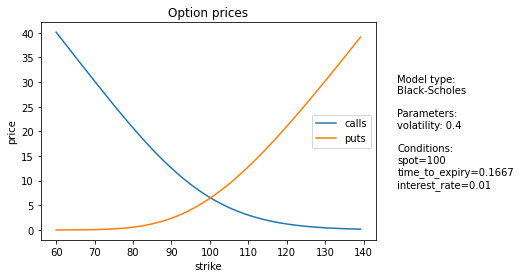

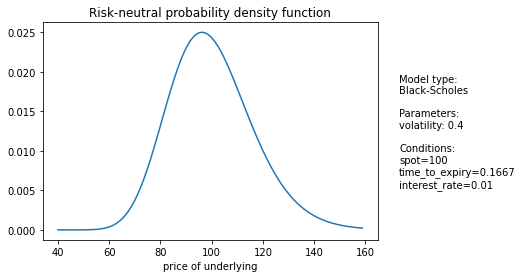

In [9]:
current_conditions = MarketConditions(spot=100, interest_rate=0.01) 
bs_model = PricingModel(
    model_name="Black-Scholes", 
    params={'volatility': 0.4}, 
    conditions= current_conditions
    )
bs_model.model.volatility
bs_model.pricing_plot(time_to_expiry=2/12, min_strike=60, max_strike=140, time_value_only=False)
bs_model.probability_distribution_plot(time_to_expiry=2/12, min_strike=40, max_strike=160)
print()


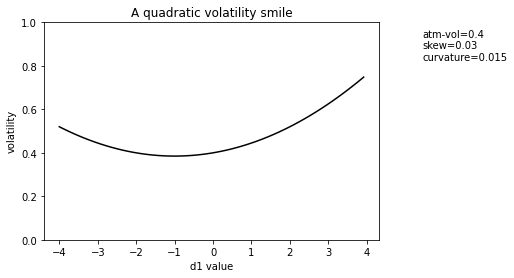

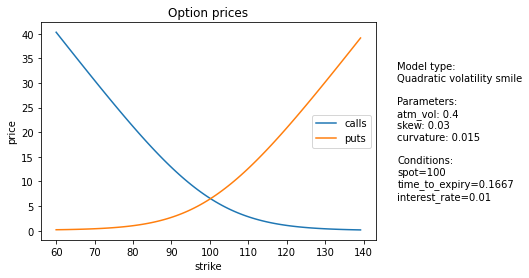

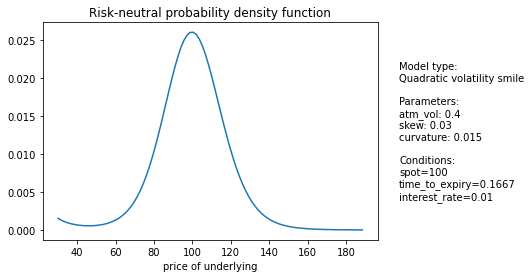

In [10]:
quad_vs_model = PricingModel(
    model_name="Quadratic volatility smile", 
    params={'atm_vol': 0.4, 'skew': 0.03, 'curvature': 0.015}, 
    conditions= current_conditions
    )
quad_vs_model.model.plot_smile()
quad_vs_model.pricing_plot(time_to_expiry=2/12, min_strike=60, max_strike=140, time_value_only=False)
quad_vs_model.probability_distribution_plot(time_to_expiry=2/12, min_strike=30, max_strike=190)
print()

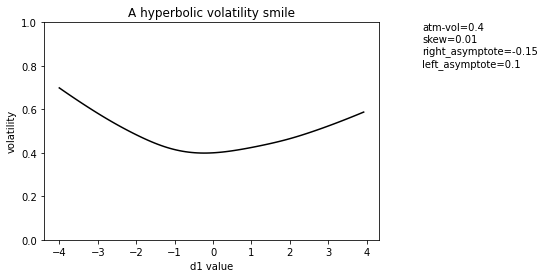

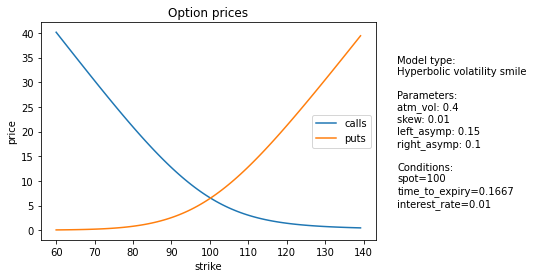

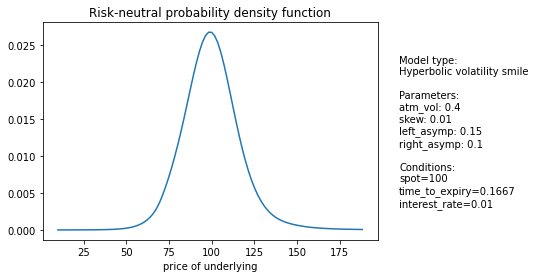

In [11]:
hyp_vs_model = PricingModel(
    model_name="Hyperbolic volatility smile", 
    params={'atm_vol': 0.4, 'skew': 0.01, 'left_asymp': 0.15, 'right_asymp' : 0.1}, 
    conditions= current_conditions
    )
hyp_vs_model.model.plot_smile()
hyp_vs_model.pricing_plot(time_to_expiry=2/12, min_strike=60, max_strike=140, time_value_only=False)
hyp_vs_model.probability_distribution_plot(time_to_expiry=2/12, min_strike=10, max_strike=190)
print()

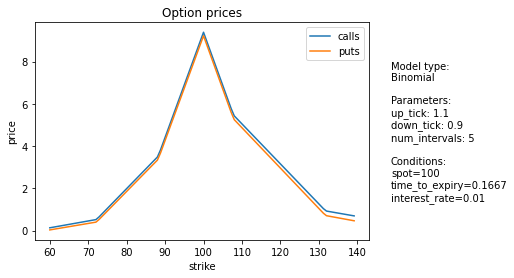

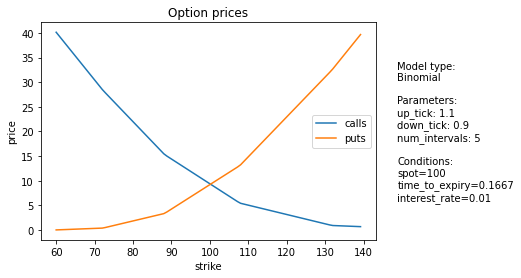

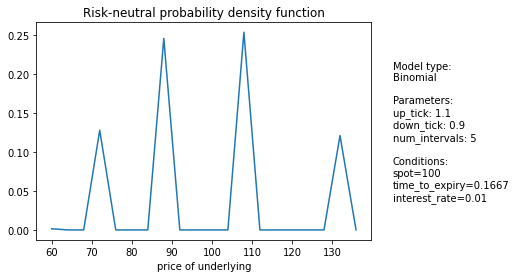

In [12]:
binomial_model = PricingModel(
    model_name="Binomial", 
    params={'up_tick': 1.1, 'down_tick': 0.9, 'num_intervals': 5}, 
    conditions= current_conditions
    )
binomial_model.pricing_plot(time_to_expiry=2/12, min_strike=60, max_strike=140, time_value_only=True)
binomial_model.pricing_plot(time_to_expiry=2/12, min_strike=60, max_strike=140, time_value_only=False)
binomial_model.probability_distribution_plot(time_to_expiry=2/12, min_strike=60, max_strike=140, precision=1, num_samples=20)
print()

## Comparison

Finally, we compare the Black-Scholes and volatility smile pricing models

In [13]:
class ModelAndParams:
    def __init__(self, model_name: str, params: str) -> None:
        self.model_name = model_name
        self.params = params

In [14]:
def compare_pricing_models(
        models_list: List[ModelAndParams],
        time_to_expiry:float, 
        conditions:MarketConditions, 
        num_samples=100):
    
    common_min_strike = conditions.min_strike_of_interest
    common_max_strike = conditions.max_strike_of_interest
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    for i, mod_params in enumerate(models_list):
        current_model = PricingModel(
            model_name=mod_params.model_name, 
            params=mod_params.params, 
            conditions= conditions
        )
        current_model_prices = current_model.pricing_plot(
            time_to_expiry=time_to_expiry,
            min_strike=common_min_strike,
            max_strike=common_max_strike,
            time_value_only=True,
            plot=False,
            num_samples=num_samples
        )
        
        if mod_params.model_name == "Binomial":
            fig_label = f"Binomial (n={mod_params.params['num_intervals']})"
        else:
            fig_label = mod_params.model_name

        ax1.plot(
            current_model_prices['strikes'],
            current_model_prices['call_prices'], label=fig_label)
        
        ax2.plot(
            current_model_prices['strikes'],
            current_model_prices['put_prices'], label=fig_label)
        
        plt.figtext(0.15+i/6, -0.1,
            f"MODEL #{i+1}:\n" +
            current_model.info_string(time_to_expiry=time_to_expiry),
            horizontalalignment ="left", verticalalignment ="top", 
            wrap = True, fontsize = 10)

    ax1.set_title("Time values for call options")
    ax1.set(xlabel="strike", ylabel ="price")
    ax1.legend()  
    ax2.set_title("Time values for put options")
    ax2.set(xlabel="strike", ylabel ="price")
    ax2.legend() 
    return

def compare_distributions(
        models_list: List[ModelAndParams],
        time_to_expiry:float, 
        conditions:MarketConditions, 
        num_samples=100
    ):
    common_min_strike = conditions.min_strike_of_interest
    common_max_strike = conditions.max_strike_of_interest

    for i, mod_params in enumerate(models_list):
        current_model = PricingModel(
            model_name=mod_params.model_name, 
            params=mod_params.params, 
            conditions= conditions
        )
        current_model_pdf = current_model.probability_distribution_plot(
            time_to_expiry=time_to_expiry, 
            min_strike=common_min_strike, 
            max_strike=common_max_strike, 
            num_samples=num_samples,
            plot=False)
        
        if mod_params.model_name == "Binomial":
            fig_label = f"Binomial (n={mod_params.params['num_intervals']})"
        else:
            fig_label = mod_params.model_name

        plt.plot(
            current_model_pdf['strikes'],
            current_model_pdf['probs'], label=fig_label)
        
        plt.figtext(0.95+i/3, 0.5,
            f"MODEL #{i+1}:\n" +
            current_model.info_string(time_to_expiry=time_to_expiry),
            horizontalalignment ="left", verticalalignment ="top", 
            wrap = True, fontsize = 10)

    plt.title("Risk-neutral distributions")
    plt.xlabel("price of underlying")
    plt.legend()  
    return

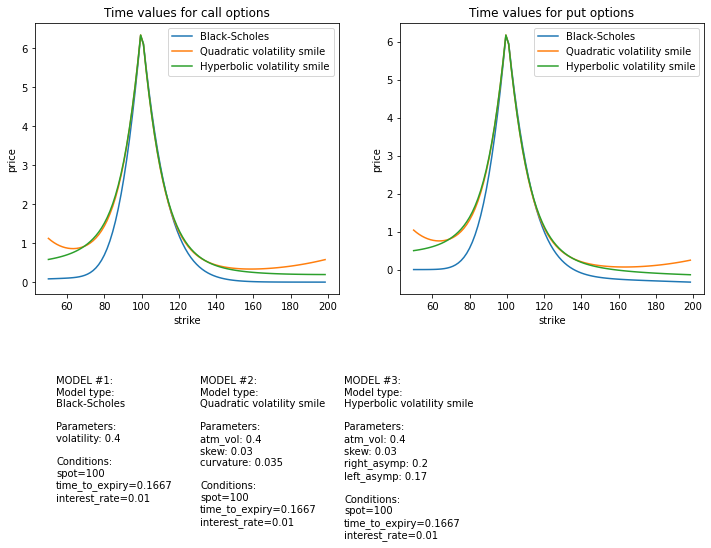

In [15]:
current_conditions = MarketConditions(spot=100, interest_rate=0.01)
current_conditions.set_min_max_strikes_of_interest(
    new_min_strike_of_interest=50, 
    new_max_strike_of_interest=200)

compare_pricing_models(
    models_list=[
        ModelAndParams(
            model_name="Black-Scholes", 
            params={'volatility': 0.4}),
        ModelAndParams(
            model_name="Quadratic volatility smile", 
            params={"atm_vol":0.4, 'skew':0.03, 'curvature':0.035}),
        ModelAndParams(
            model_name="Hyperbolic volatility smile", 
            params={"atm_vol":0.4, 'skew':0.03, 'right_asymp':0.2, 'left_asymp':0.17})
    ], 
    time_to_expiry=2/12,
    conditions=current_conditions
)

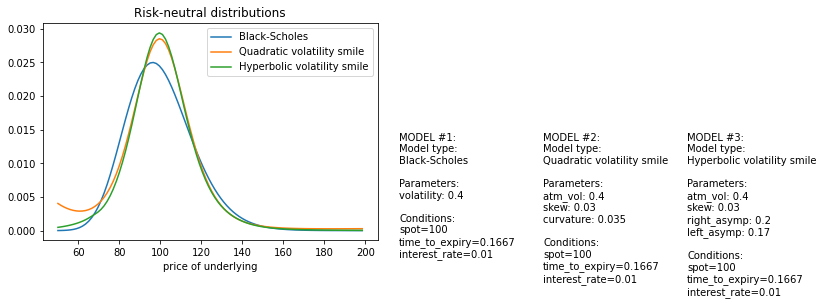

In [16]:

compare_distributions(
    models_list=[
        ModelAndParams(
            model_name="Black-Scholes", 
            params={'volatility': 0.4}),
        ModelAndParams(
            model_name="Quadratic volatility smile", 
            params={"atm_vol":0.4, 'skew':0.03, 'curvature':0.035}),
        ModelAndParams(
            model_name="Hyperbolic volatility smile", 
            params={"atm_vol":0.4, 'skew':0.03, 'right_asymp':0.2, 'left_asymp':0.17})
    ], 
    time_to_expiry=2/12,
    conditions=current_conditions
)

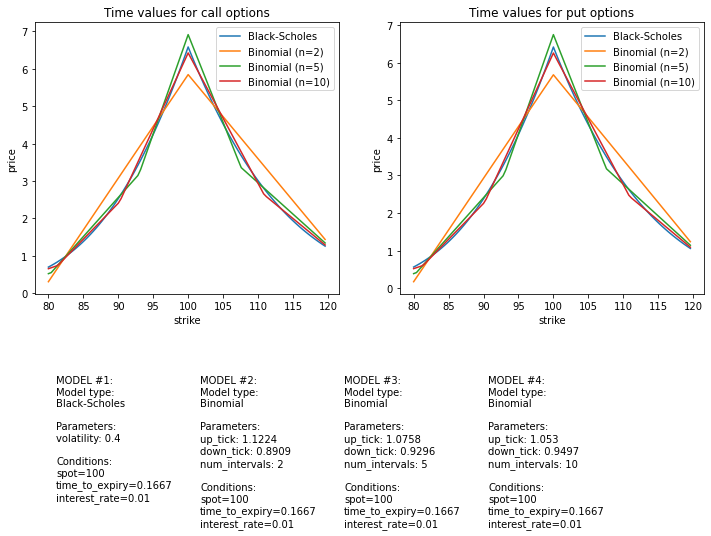

In [17]:
current_conditions = MarketConditions(spot=100, interest_rate=0.01)
current_conditions.set_min_max_strikes_of_interest(
    new_min_strike_of_interest=80, 
    new_max_strike_of_interest=120)

option_time_to_expiry = 2/12
bs_vol = 0.4

models_to_compare = [
        ModelAndParams(
            model_name="Black-Scholes", 
            params={'volatility': bs_vol})
            ]
for n in [2, 5, 10]:
    models_to_compare.append(
        ModelAndParams(
            model_name="Binomial", 
            params={
                'up_tick': exp(bs_vol*sqrt(option_time_to_expiry/n)), 
                'down_tick': exp(-bs_vol*sqrt(option_time_to_expiry/n)), 
                'num_intervals': n}
    ))

compare_pricing_models(
    models_list=models_to_compare,
    time_to_expiry=option_time_to_expiry,
    conditions=current_conditions,
    num_samples=100
)

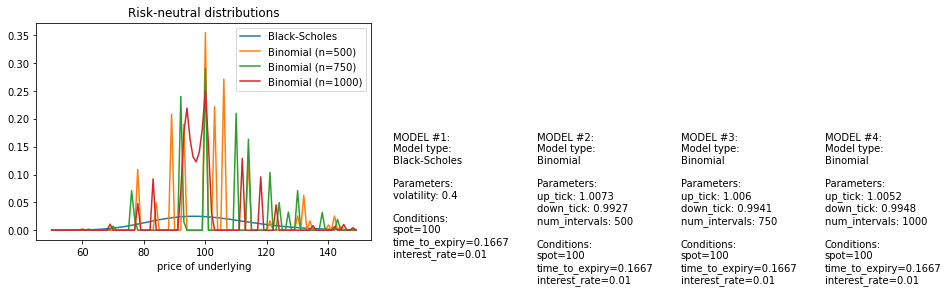

In [18]:
current_conditions.set_min_max_strikes_of_interest(
    new_min_strike_of_interest=50, 
    new_max_strike_of_interest=150)

models_to_compare_pdfs = [
        ModelAndParams(
            model_name="Black-Scholes", 
            params={'volatility': bs_vol})
            ]
for n in [500, 750, 1000]:
    models_to_compare_pdfs.append(
        ModelAndParams(
            model_name="Binomial", 
            params={
                'up_tick': exp(bs_vol*sqrt(option_time_to_expiry/n)), 
                'down_tick': exp(-bs_vol*sqrt(option_time_to_expiry/n)), 
                'num_intervals': n}
    ))

compare_distributions(
    models_list=models_to_compare_pdfs,
    time_to_expiry=option_time_to_expiry,
    conditions=current_conditions,
    num_samples=100
)